In [186]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.optimizers import SGD


#### **Load the data**

In [162]:
df=pd.read_csv("data_for_test.csv", ";")
print(df.shape)
df.head()

(17754, 29)


C:\Users\maxim\AppData\Local\Temp\ipykernel_2312\3008866578.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df=pd.read_csv("data_for_test.csv", ";")


,Unnamed: 0,date,item_id,quantity,promotions,item_category,demographic_density,national_day,extended_weekend,special_day,...,cloud_cov,opening_days,mon_avg_attendance,tue_avg_attendance,wed_avg_attendance,thu_avg_attendance,fri_avg_attendance,sat_avg_attendance,sun_avg_attendance,is_closed
0,0,2016-01-02,81541ablvcs82a5df5d,706.0,0.0,4,979.75,0.0,0.5,0.0,...,97.500000,1-1-1-1-1-1-0,0.76902,0.740365,0.765486,0.762859,0.841847,1.0,0.0,0
1,1,2016-01-03,81541ablvcs82a5df5d,0.0,0.0,4,979.75,0.0,0.5,1.0,...,87.500000,1-1-1-1-1-1-0,0.76902,0.740365,0.765486,0.762859,0.841847,1.0,0.0,1
2,2,2016-01-04,81541ablvcs82a5df5d,619.0,0.0,4,979.75,0.0,0.0,0.0,...,80.000000,1-1-1-1-1-1-0,0.76902,0.740365,0.765486,0.762859,0.841847,1.0,0.0,0
3,3,2016-01-05,81541ablvcs82a5df5d,571.0,0.0,4,979.75,0.0,0.0,0.0,...,51.250000,1-1-1-1-1-1-0,0.76902,0.740365,0.765486,0.762859,0.841847,1.0,0.0,0
4,4,2016-01-06,81541ablvcs82a5df5d,689.0,0.0,4,979.75,0.0,0.0,0.0,...,83.333333,1-1-1-1-1-1-0,0.76902,0.740365,0.765486,0.762859,0.841847,1.0,0.0,0


#### **Look for useless features, categorical features and continuous features**

In [163]:
# print sets of values
for name in df.columns : 
    print(f"{name}: {set(df[name])}")

Unnamed: 0: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

"Promotions", "item_category" seem to be useless since they contain only one value.    
**The features containing integer values will be considered as categorical.**

#### **Transform and cast the data**

In [164]:
# remove "Promotions", "item_category"
df = df.drop(['promotions', 'item_category', 'Unnamed: 0'], axis=1)

# transform 'date' column to year, month, day columns
df['year'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
df['month'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
df['day'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)
df = df.drop(['date'], axis=1)

# transform 'item_id' column to integer
le = LabelEncoder()
df['item_id_int'] = le.fit_transform(df['item_id'])
df = df.drop(['item_id'], axis=1)

# split the 'opening_days' column into seven separate columns
df[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']] = df['opening_days'].str.split('-', expand=True).astype(int)
df = df.drop(['opening_days'], axis=1)


#### **Select categorical and continuous data**

In [165]:
cat_features_names=[]
cont_features_names=[]

for name in df.columns : 
    # if the type of the first element of the set is integer, then it is a categorical feature
    if(type(set(df[name]).pop())==int):
        cat_features_names.append(name)
    else : 
        cont_features_names.append(name)

print("cat_features_names : ", cat_features_names)
print("cont_features_names : ", cont_features_names)

cat_features_names :  ['day_of_week', 'day_of_month', 'month', 'year', 'is_closed', 'day', 'item_id_int', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
cont_features_names :  ['quantity', 'demographic_density', 'national_day', 'extended_weekend', 'special_day', 'holidays', 'temp_min', 'temp_max', 'rain', 'wind', 'cloud_cov', 'mon_avg_attendance', 'tue_avg_attendance', 'wed_avg_attendance', 'thu_avg_attendance', 'fri_avg_attendance', 'sat_avg_attendance', 'sun_avg_attendance']


#### **Analyse the features : run a random forest**

In [174]:
# one-hot encode categorical features
enc = OneHotEncoder(sparse=False)
X_cat = enc.fit_transform(df[cat_features_names])

# normalize continuous features
scaler = StandardScaler()
X_cont = scaler.fit_transform(df[cont_features_names].drop(['quantity'], axis=1))  # drop the target

# combine one-hot encoded categorical features and normalized continuous features
X = np.concatenate([X_cat, X_cont], axis=1)
y = df['quantity']

In [177]:
# Train a random forest regression model
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importance and sort in descending order
importance = rf.feature_importances_
sorted_idx = importance.argsort()[::-1]

# Print the feature ranking
for i in sorted_idx:
    print(f"{importance[i]}")

0.2224930681804544
0.12067202932078053
0.08367232872587309
0.07375079887067754
0.054616798653504633
0.0527298517350416
0.04374525486014701
0.03452065561363616
0.03437034834265922
0.032771588196841665
0.026793352685123176
0.026334186864091884
0.023008181339463044
0.011545037265343125
0.010547409663395133
0.008679843043195114
0.008656719855075871
0.007906070770497216
0.007509743292901403
0.007192729085044026
0.006501527203079835
0.006435348808589112
0.005950439636973887
0.005428349801367326
0.0044073171003974594
0.004393076681307278
0.003842510197916962
0.0036224365802929913
0.003583835765850198
0.003295044462111148
0.0029608432562417196
0.002781300953297763
0.0027041740256310122
0.002621206652772084
0.0026130571908745586
0.002399378673943609
0.002231023651260405
0.0020916188860786718
0.002001866549744708
0.0018228092687556513
0.0016173479909252586
0.0014166531440880565
0.0013070805550874838
0.0012885296931920579
0.001270293138897853
0.0011106489820390637
0.0010857203964366692
0.00099347

In [178]:
# Print useless features
useless_names=[]
for i in sorted_idx:
    if importance[i]==0. : 
        print(f"{importance[i]}")

0.0
0.0
0.0
0.0
0.0
0.0


On the 135 features, only 6 of them does not contributes at all the prediction. 

### **Run an LSTM model for the prediction**

To forecast the next seven days of a time series, we need to use a forecasting model that can capture both the temporal dependencies and the relationships between the target variable and the covariates. To do so, we will use am LSTM (Long Short Term Memory Neural Network).

In [353]:
# Split the data into training, validation, and test sets
train_data, train_label = np.array(X[:14754, :]), np.array(y[:14754])
val_data, val_label = np.array(X[14754:16738, :]), np.array(y[14754:16738])
test_data, test_label = np.array(X[16738:,:]), np.array(y[16738:])

In [354]:
# Prepare the training data
def create_dataset(X, y, window_size, prediction):
    Xs, ys = [], []
    for i in range(len(X) - window_size-prediction):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size:i+window_size+prediction])
    return np.array(Xs), np.array(ys)

In [318]:
X_test, y_test = create_dataset(np.array(X[17738:,:]), np.array(y[17738:]), window_size)

In [355]:
window_size = 30
prediction = 7
X_train, y_train = create_dataset(train_data, train_label, window_size, prediction)
X_val, y_val = create_dataset(val_data, val_label, window_size, prediction)
X_test, y_test = create_dataset(test_data, test_label, window_size, prediction)

In [363]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/40
460/460 [==============================] - 13s 21ms/step - loss: 814492.8750 - val_loss: 360631.0000
Epoch 2/40
460/460 [==============================] - 9s 19ms/step - loss: 771235.1875 - val_loss: 336523.7812
Epoch 3/40
460/460 [==============================] - 9s 19ms/step - loss: 732510.8750 - val_loss: 314695.6875
Epoch 4/40
460/460 [==============================] - 9s 19ms/step - loss: 696225.8750 - val_loss: 294852.4375
Epoch 5/40
460/460 [==============================] - 8s 18ms/step - loss: 662141.1875 - val_loss: 276897.8438
Epoch 6/40
460/460 [==============================] - 9s 19ms/step - loss: 630064.1875 - val_loss: 260657.7812
Epoch 7/40
460/460 [==============================] - 9s 19ms/step - loss: 599855.9375 - val_loss: 246094.7969
Epoch 8/40
460/460 [==============================] - 9s 19ms/step - loss: 571427.0000 - val_loss: 233113.8906
Epoch 9/40
460/460 [==============================] - 8s 18ms/step - loss: 544732.6250 - val_loss: 221691.3281


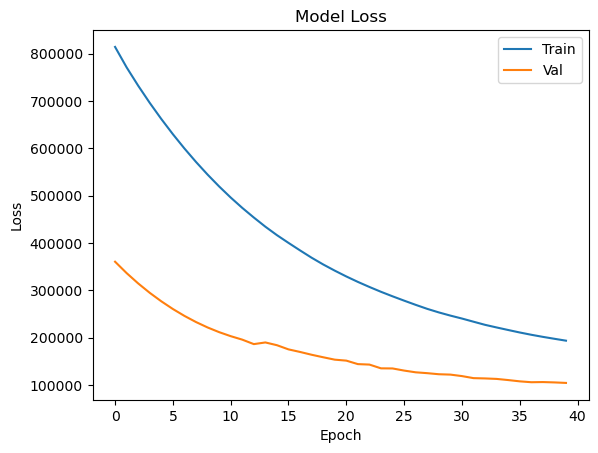

In [364]:
# Plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#### **Test the model**

31/31 [==============================] - 0s 8ms/step


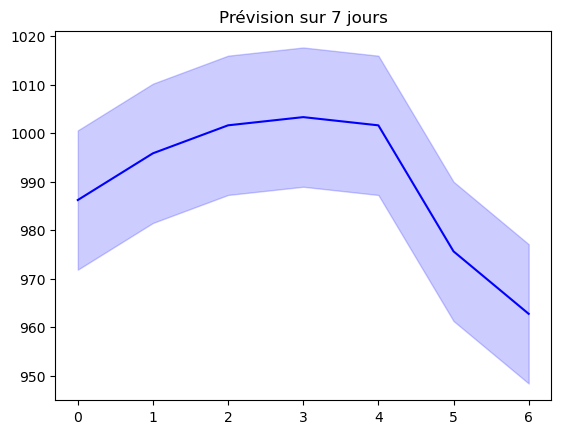

In [398]:
# Generate predictions for the last 7 days
forecast = model.predict(X_test).squeeze()[-7:]

# Calculate the mean and variance of the predictions
y_pred_mean = forecast.mean().flatten()
y_pred_std = forecast.std().flatten()

x_range = np.arange(7)
plt.plot(x_range, forecast, 'b-', label='forecast')
plt.fill_between(x_range, forecast - y_pred_std, forecast + y_pred_std, color='b', alpha=0.2)

plt.title("Prévision sur 7 jours")
plt.show()

PS : J'ai écrit le code en anglais par habitude mais je parle bien évidemment francais.